In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.layers import *
import tensorflow.keras as K
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

tf.keras.backend.set_floatx("float64")

In [2]:
def import_data():

    ds,info = tfds.load('caltech_birds2010', split='all',with_info=True)
    ds_train = ds.skip(300)
    ds_test = ds.take(300)
    return ds_train,ds_test,info

In [3]:
ds_train_raw,ds_test_raw,info = import_data()

In [4]:
IMAGE_SIZE = 128
def pre_process_image(record):
    
    image = record["image"]
    image = image / 255
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    
    seg_image = record["segmentation_mask"]
    seg_image = tf.image.resize(seg_image, (IMAGE_SIZE, IMAGE_SIZE))

    seg_image = tf.cast(seg_image, tf.uint8)
    seg_image = seg_image % 2
    seg_image = tf.cast(seg_image, tf.float32)
    return image,seg_image

resize_train = ds_train_raw.map(pre_process_image)
resize_test = ds_test_raw.map(pre_process_image)

In [5]:

inputs = K.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name="image")

conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(2)(conv1)

conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(2)(conv2)

conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(2)(conv3)

conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(2)(conv4)

conv5 = Conv2D(256, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
pool4 = MaxPooling2D(2)(conv5)

convT1 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)

skip1 = concatenate([convT1, conv4])
conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(skip1)
conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(conv6)
convT2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)

skip2 = concatenate([convT2, conv3])
conv7 = Conv2D(64, (3,3), activation='relu', padding='same')(skip2)
conv7 = Conv2D(64, (3,3), activation='relu', padding='same')(conv7)
convT3 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)

skip3 = concatenate([convT3, conv2])
conv8 = Conv2D(32, (3,3), activation='relu', padding='same')(skip3)
conv8 = Conv2D(32, (3,3), activation='relu', padding='same')(conv8)
convT4 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)

skip4 = concatenate([convT4, conv1])
conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(skip4)
conv10 = Conv2D(16, (1,1), strides=(1,1), padding='same', name = "c10")(conv9)

In [6]:
outputs = Conv2D(1, (1,1), activation="sigmoid", padding="same")(conv10)
model = K.Model(inputs, outputs)

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)

    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):

    return (1-dice_coef(y_true, y_pred))

In [10]:
ds_train = resize_train.batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = resize_test.batch(128).prefetch(tf.data.AUTOTUNE)

In [12]:
import time

model.compile(optimizer=K.optimizers.RMSprop(learning_rate=0.0001), loss=diceCoefLoss, metrics = ['Accuracy', 'Precision', 'Recall', 'AUC',K.metrics.MeanIoU(num_classes=2),dice_coef])

callbacks = [
    K.callbacks.ModelCheckpoint("bird_segmentation.h5", save_best_only=True, monitor="val_dice_coef",mode="max"),
    #K.callbacks.EarlyStopping("val_dice_coef",mode="max")

]

# Train the model, doing validation at the end of each epoch.
epochs = 80


In [13]:
start = time.time()
history = model.fit(ds_train,validation_data=ds_test,epochs=epochs,verbose=2,callbacks=callbacks)
end = time.time()

Epoch 1/80
45/45 - 178s - loss: 0.7030 - Accuracy: 0.2595 - precision: 0.1757 - recall: 0.9718 - auc: 0.6432 - mean_io_u: 0.4326 - dice_coef: 0.2976 - val_loss: 0.6352 - val_Accuracy: 0.4873 - val_precision: 0.2366 - val_recall: 0.9666 - val_auc: 0.7425 - val_mean_io_u: 0.5390 - val_dice_coef: 0.3660 - 178s/epoch - 4s/step
Epoch 2/80
45/45 - 179s - loss: 0.4965 - Accuracy: 0.7650 - precision: 0.3797 - recall: 0.7196 - auc: 0.7590 - mean_io_u: 0.5482 - dice_coef: 0.5030 - val_loss: 0.5395 - val_Accuracy: 0.6583 - val_precision: 0.3101 - val_recall: 0.8979 - val_auc: 0.7671 - val_mean_io_u: 0.5028 - val_dice_coef: 0.4636 - 179s/epoch - 4s/step
Epoch 3/80
45/45 - 180s - loss: 0.4607 - Accuracy: 0.8129 - precision: 0.4471 - recall: 0.6732 - auc: 0.7671 - mean_io_u: 0.5861 - dice_coef: 0.5393 - val_loss: 0.4441 - val_Accuracy: 0.8430 - val_precision: 0.5150 - val_recall: 0.6044 - val_auc: 0.7585 - val_mean_io_u: 0.5966 - val_dice_coef: 0.5619 - 180s/epoch - 4s/step
Epoch 4/80
45/45 - 182s -

Epoch 27/80
45/45 - 197s - loss: 0.2715 - Accuracy: 0.9092 - precision: 0.7039 - recall: 0.7556 - auc: 0.8645 - mean_io_u: 0.6276 - dice_coef: 0.7285 - val_loss: 0.2779 - val_Accuracy: 0.9167 - val_precision: 0.7880 - val_recall: 0.6679 - val_auc: 0.8358 - val_mean_io_u: 0.5585 - val_dice_coef: 0.7264 - 197s/epoch - 4s/step
Epoch 28/80
45/45 - 212s - loss: 0.2661 - Accuracy: 0.9113 - precision: 0.7107 - recall: 0.7593 - auc: 0.8672 - mean_io_u: 0.6262 - dice_coef: 0.7339 - val_loss: 0.2610 - val_Accuracy: 0.9163 - val_precision: 0.7487 - val_recall: 0.7312 - val_auc: 0.8602 - val_mean_io_u: 0.5916 - val_dice_coef: 0.7441 - 212s/epoch - 5s/step
Epoch 29/80
45/45 - 209s - loss: 0.2636 - Accuracy: 0.9121 - precision: 0.7132 - recall: 0.7617 - auc: 0.8678 - mean_io_u: 0.6347 - dice_coef: 0.7364 - val_loss: 0.2581 - val_Accuracy: 0.9167 - val_precision: 0.7471 - val_recall: 0.7382 - val_auc: 0.8616 - val_mean_io_u: 0.6236 - val_dice_coef: 0.7476 - 209s/epoch - 5s/step
Epoch 30/80
45/45 - 24

Epoch 53/80
45/45 - 241s - loss: 0.2019 - Accuracy: 0.9340 - precision: 0.7889 - recall: 0.8074 - auc: 0.8926 - mean_io_u: 0.7550 - dice_coef: 0.7981 - val_loss: 0.2392 - val_Accuracy: 0.9175 - val_precision: 0.7196 - val_recall: 0.8077 - val_auc: 0.8821 - val_mean_io_u: 0.7516 - val_dice_coef: 0.7650 - 241s/epoch - 5s/step
Epoch 54/80
45/45 - 237s - loss: 0.1984 - Accuracy: 0.9354 - precision: 0.7940 - recall: 0.8095 - auc: 0.8941 - mean_io_u: 0.7592 - dice_coef: 0.8017 - val_loss: 0.2351 - val_Accuracy: 0.9288 - val_precision: 0.8248 - val_recall: 0.7138 - val_auc: 0.8527 - val_mean_io_u: 0.7050 - val_dice_coef: 0.7695 - 237s/epoch - 5s/step
Epoch 55/80
45/45 - 243s - loss: 0.1986 - Accuracy: 0.9353 - precision: 0.7938 - recall: 0.8094 - auc: 0.8939 - mean_io_u: 0.7606 - dice_coef: 0.8015 - val_loss: 0.2248 - val_Accuracy: 0.9287 - val_precision: 0.7948 - val_recall: 0.7571 - val_auc: 0.8692 - val_mean_io_u: 0.7334 - val_dice_coef: 0.7784 - 243s/epoch - 5s/step
Epoch 56/80
45/45 - 25

Epoch 79/80
45/45 - 251s - loss: 0.1527 - Accuracy: 0.9507 - precision: 0.8472 - recall: 0.8474 - auc: 0.9165 - mean_io_u: 0.8164 - dice_coef: 0.8473 - val_loss: 0.2309 - val_Accuracy: 0.9281 - val_precision: 0.8035 - val_recall: 0.7383 - val_auc: 0.8595 - val_mean_io_u: 0.7457 - val_dice_coef: 0.7745 - 251s/epoch - 6s/step
Epoch 80/80
45/45 - 221s - loss: 0.1475 - Accuracy: 0.9524 - precision: 0.8526 - recall: 0.8524 - auc: 0.9195 - mean_io_u: 0.8212 - dice_coef: 0.8525 - val_loss: 0.2280 - val_Accuracy: 0.9252 - val_precision: 0.7652 - val_recall: 0.7796 - val_auc: 0.8735 - val_mean_io_u: 0.7611 - val_dice_coef: 0.7752 - 221s/epoch - 5s/step


In [14]:
print(end-start)

17528.246010780334


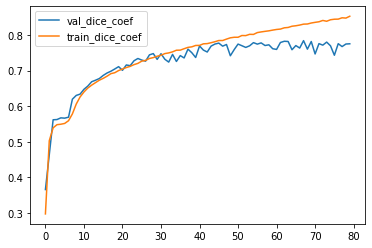

In [15]:

plt.plot(history.history["val_dice_coef"],label= "val_dice_coef")
plt.plot(history.history["dice_coef"],label="train_dice_coef")
plt.legend()

In [ ]:
model 

In [19]:
model.load_weights("bird_segmentation.h5")

In [20]:
dice_coeff_vals = []
n = int(resize_test.cardinality())
for image in iter(resize_test):

    mask = image[1]
    pred = model.predict(tf.reshape(image[0],(-1,128,128,3)))
    dice_coeff_vals.append(dice_coef(pred[0],mask))

dice_coeff_mean = sum(dice_coeff_vals)/n
dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5

In [21]:
float(dice_coeff_mean)

0.7449637055397034

In [22]:
float(dice_coeff_std)

0.19377823173999786